SmartRedis Library@18-00-32:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@18-00-32:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO
Input cell centers datasets available.
Input field datasets available.
torch.Size([2946, 1])
torch.Size([2946, 2])
18:00:32 argo SmartSim[343082] INFO Stopping model orchestrator_0 with job name orchestrator_0-CUBDMP3BZOKE


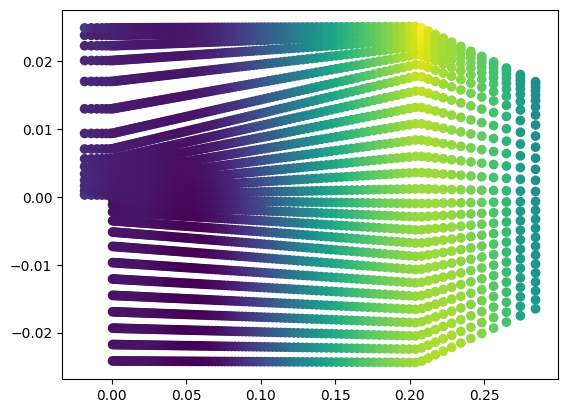

In [1]:
from smartsim import Experiment
from smartredis import Client
import torch
import numpy as np
from matplotlib import pyplot as plt

def sort_tensors_by_names(tensors, tensor_names):
    # Pair each tensor with its name and sort by the name
    pairs = sorted(zip(tensor_names, tensors))

    # Extract the sorted tensors
    tensor_names_sorted, tensors_sorted = zip(*pairs)

    # Convert back to list if needed
    tensor_names_sorted = list(tensor_names_sorted)
    tensors_sorted = list(tensors_sorted)

    return tensors_sorted, tensor_names_sorted


# Set up the execution of the foamSmartSimMapField application 
# as a SmartSim Experiment. 
exp = Experiment("foam-smartsim-map-fields", launcher="local")

db = exp.create_database(port=8000,       # database port
                         interface="lo")  # network interface to use
exp.start(db)

# Connect the python client to the smartredis database
client = Client(address=db.get_address()[0], cluster=False)

# Serial execution run settings for foamSmartSimMapFields
num_mpi_ranks = 1
run_settings_serial = exp.create_run_settings(exe="foamSmartSimMapFields", 
                                              exe_args="-inputCase pitzDailyCoarse -outputCase pitzDaily -field p")

# MPI parallel run settings for foamSmartSimMapFields - run_command can be "slurm" on a cluster.
# n_mpi_ranks = 4
# run_settings_parallel = exp.create_run_settings(exe="foamSmartSimMapFIelds", 
#                                                 exe_args="-inputCase pitzDailyCoarse -outputCase pitzDaily -field p -parallel", 
#                                                 run_command="mpirun", 
#                                                 run_args={"np": f"{num_mpi_ranks}"})

openfoam_mapfields_model = exp.create_model(name="foamSmartSimMapFields", run_settings=run_settings_serial)

try:
    # Run foamSmartSimMapFields and do not block
    exp.start(openfoam_mapfields_model, block=False)

    # Poll the cell centers in smartredis
    input_cell_centers_updated = client.poll_list_length("inputCentersDatasetList", 
                                                          num_mpi_ranks, 10, 1000);
    if (not input_cell_centers_updated):     
        raise ValueError("Input cell centers dataset list not available in smartredis.")
    else:
        print ("Input cell centers datasets available.")

    # Poll the input field in smartredis 
    input_field_updated = client.poll_list_length("inputFieldDatasetList", 
                                                  num_mpi_ranks, 10, 1000);
    if (not input_field_updated):     
        raise ValueError("Input field dataset list not available in smartredis.")
    else:
        print ("Input field datasets available.")

    # - Get the datasets
    input_centers_datasets = client.get_datasets_from_list("inputCentersDatasetList");  
    input_field_datasets = client.get_datasets_from_list("inputFieldDatasetList");

    # - Agglomerate all input data tensors from smartredis for the ML model training
    input_centers = []
    input_centers_names = []
    input_field = []
    input_field_names = []

    # Loop over all datasets that agglomerate input cell center tensors and input field tensors per MPI rank
    # and append the tensors to the global list of tensors along with their names. Sort the tensors w.r.t.
    # their names, i.e. w.r.t MPI rank to make sure that a cell center from an MPI rank corresponds to the 
    # right field data from the same MPI rank.
    for input_centers_dset, input_field_dset in zip(input_centers_datasets, input_field_datasets):
        input_centers_tensor_names = input_centers_dset.get_tensor_names()
        input_field_tensor_names = input_field_dset.get_tensor_names()
        for input_centers_name,input_field_name in zip(input_centers_tensor_names,input_field_tensor_names):
            
            input_centers.append(input_centers_dset.get_tensor(input_centers_name))
            input_centers_names.append(input_centers_name)
            
            input_field.append(input_field_dset.get_tensor(input_field_name))
            input_field_names.append(input_field_name)
            
    input_centers, input_center_names = sort_tensors_by_names(input_centers, input_centers_names)
    input_field, input_field_names = sort_tensors_by_names(input_field, input_field_names)
    
    # Flatten the training data
    input_field = torch.from_numpy(np.vstack(input_field)).float()
    input_centers = torch.from_numpy(np.vstack(input_centers)).float()

    # TODO(TM): hardcoded 2D dimensions, remove in a 3D simulation, adapt if 2D solution dimensions differ.'
    # FIXME(TM): use polyMesh::solutionD
    field_rank_found = client.poll_tensor("input_field_rank", 10, 1000)
    if (not field_rank_found):     
            raise ValueError("Input field rank not available in smartredis.")
    input_field_rank = client.get_tensor("input_field_rank")

    if (input_field_rank[0] > 0):
        input_field = input_field[:, :2]
    input_centers = input_centers[:, :2]

    print(input_field.shape)
    print (input_centers.shape)
    vis_centers = list(zip(*input_centers))
    if (input_field_rank[0] == 0):
        plt.scatter(vis_centers[0], vis_centers[1], c=input_field, cmap='viridis')


    # Train an ML model M(cell_center, theta), M: cell_center -> input_field

    # Perform forward inference of the model in smartredis using cell_centers as input and store output. 

    # Save the key in smartredis that forward pass has completed.

except Exception as e:
    print("Caught an exception: ", str(e))
    
finally:
    exp.stop(db)